## 1

直接由定义式计算傅里叶变换的脚本如下：

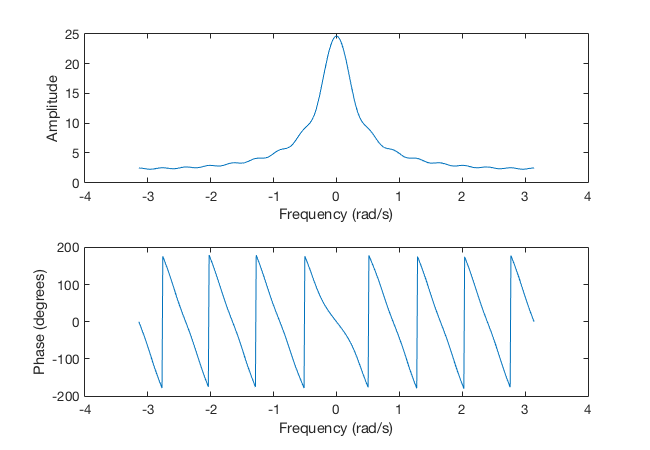

In [2]:
%plot -s 650,450
n=-8:8; x=1.2.^n;
N=2.^9;
w=linspace(-pi,pi,N+1);
y1=x*exp(-1j*n'*w);      %DFT by definiton

subplot(2,1,1); plot(w,abs(y1));
xlabel('Frequency (rad/s)'); ylabel('Amplitude');
subplot(2,1,2); plot(w,angle(y1)*180/pi);
xlabel('Frequency (rad/s)'); ylabel('Phase (degrees)');

用fft函数计算的脚本如下，因为原信号是从$n=-8$开始的，为了使计算得到的值与上面的结果相同，需要对信号进行一个时移变换（即在频域上加上一个相移，见脚本的第3行）：

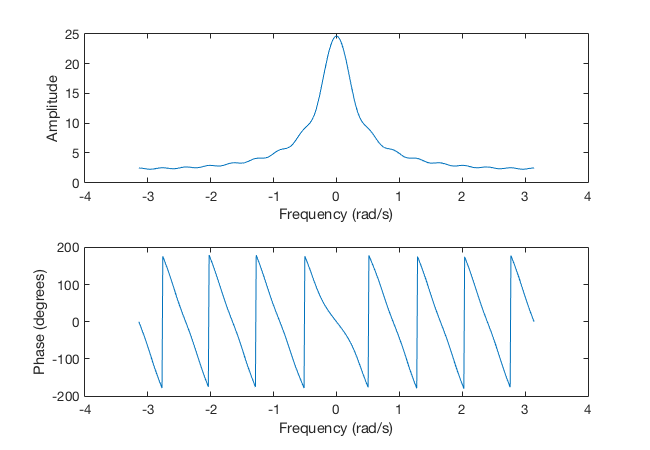

In [3]:
y2=fftshift(fft(x,N));  %DFT by FFT
y2=[y2, y2(1)];
y2=y2.*exp(-1j*w*(-8));
if(sum(abs(y2-y1))>1.e-6) 
    error 'y2 and y1 not equal to each other.';
end
subplot(2,1,1); plot(w,abs(y2));
xlabel('Frequency (rad/s)'); ylabel('Amplitude');
subplot(2,1,2); plot(w,angle(y2)*180/pi);
xlabel('Frequency (rad/s)'); ylabel('Phase (degrees)');

从上两张图可以看出，两者所得的结果完全相同。因此也验证了对于有限长离散时间信号，快速傅里叶变换所得的结果就是信号傅里叶变换在一个周期内的采样值。

上面的脚本中表明无论是通过定义式还是通过FFT，傅里叶变换都可以简单到一条MATLAB命令即可完成计算，但实际上两者的计算量是不同的。执行以下的脚本可以看出FFT所用的时间远小于按照傅里叶变换定义式计算所用的时间，且$n$越大，两者的差距越大：

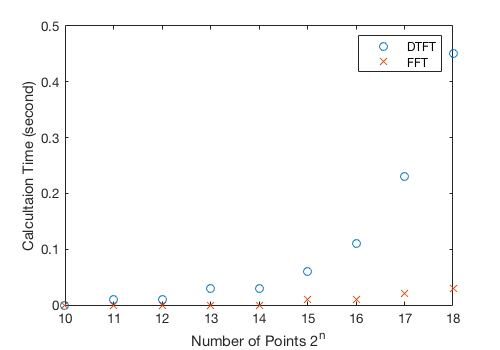

In [4]:
%plot -s 500,350
T1=zeros(1,9); T2=T1;
for k=1:9
    N=2.^(k+9);
    w=linspace(-pi,pi,N+1);
    t=cputime; y=x*exp(-1j*n'*w); T1(k)=cputime-t;
    t=cputime; y=fft(x,N); T2(k)=cputime-t;
end
N=(1:9)+9;
plot(N,T1,'O',N,T2,'X');
xlabel('Number of Points 2^n');
ylabel('Calcultaion Time (second)');
legend('DTFT','FFT')

## 2

信号的各频率分量分别为50, 100和150 Hz。不妨取采样频率为420 Hz, 并截取大于1/50\*100秒的信号进行分析：

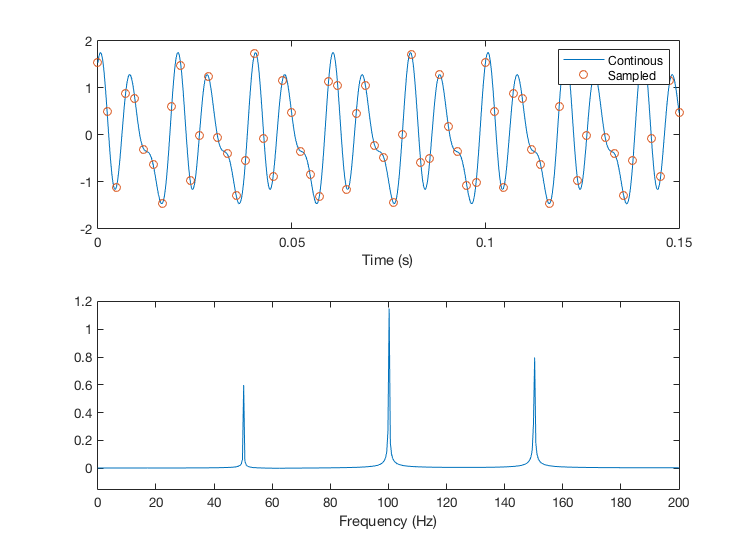

In [5]:
%plot -s 750,550
Ts=1/420; tf=1/50*100;
N=2^nextpow2(tf/Ts);
w=linspace(-1,(N-1)/N,N)*pi/Ts;

t=(0:N-1)*Ts;
x=0.5*sin(100*pi*t)+cos(200*pi*t)+0.75*sin(300*pi*t+pi/4);
y=fftshift(fft(x,N))*Ts;

t1=linspace(0,0.15,500);
x1=0.5*sin(100*pi*t1)+cos(200*pi*t1)+0.75*sin(300*pi*t1+pi/4);
subplot(2,1,1); plot(t1,x1,t,x,'o'); 
axis([0,0.15,-2,2]); xlabel('Time (s)');
legend('Continous', 'Sampled')
subplot(2,1,2); plot(w/2/pi,abs(y));
axis([0,200,-0.15,1.2]); xlabel('Frequency (Hz)');

加入噪声：

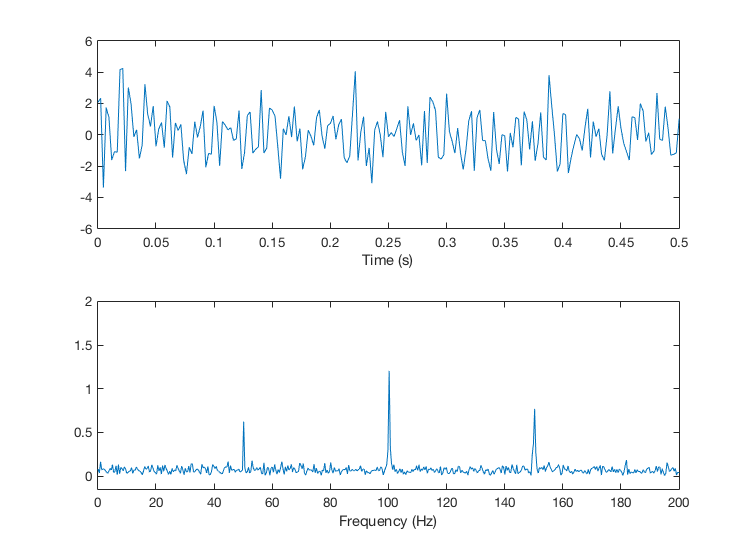

In [6]:
sn=randn(size(x));
xn=x+sn;
yn=fftshift(fft(xn,N))*Ts;

subplot(2,1,1); plot(t,xn);
axis([0,0.5,-6,6]); xlabel('Time (s)');
subplot(2,1,2); plot(w/2/pi,abs(yn));
axis([0,200,-0.15,2]); xlabel('Frequency (Hz)');

通过频谱可以清楚地看出信号的各个频率分量（分别为50Hz, 100Hz和150hz），由于噪声的频谱仍是噪声（见以下的脚本和图），因此时域上信号即使淹没在噪声中，在频域上仍能很好地分辨。

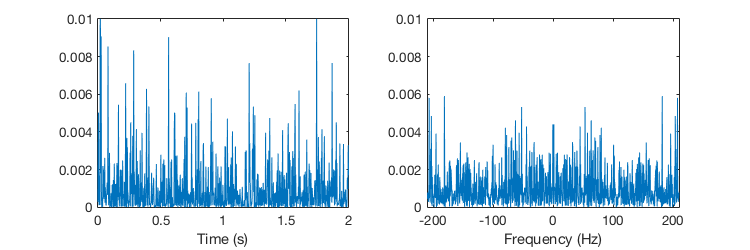

In [7]:
%plot -s 750,250
ysn=fftshift(fft(sn,N))*Ts;
et=sum(abs(sn).^2)*Ts; ef=sum(abs(ysn).^2)/Ts/N;
if(abs(et-ef)>1.e-8)
    error 'Energy not inconsistent.'
end
subplot(1,2,1); plot(t,abs(sn).^2*Ts/et); 
axis([0,tf,0,0.01]); xlabel('Time (s)');
subplot(1,2,2); plot(w/2/pi,abs(ysn).^2/Ts/N/et);
axis([-210,210,0,0.01]); xlabel('Frequency (Hz)');

为便于比较，上图中的信号大小经过了归一化。通过脚本也可以看出变换前后帕斯瓦尔定理成立。

## 3

首先根据时间常数$\tau=RC$确定了较为合适的时间区间、样本个数和采样时间间隔:

In [8]:
C=22e-6; R=510;
tau=R*C;
tf=tau*50;
Ts=tau/50;
N=2^nextpow2(tf/Ts);

t=(0:N-1)*Ts;

然后给出电路的频率响应，如已安装Signal Processing工具箱，可用`freqs`函数：

In [9]:
w=logspace(0,5,N);
%H1=freqs([0 1],[tau 1],w);
%H2=freqs([tau 0],[tau 1],w);
jwRC=1j*tau*w;
H1=1./(1+jwRC);
H2=jwRC./(1+jwRC);

画出低通和高通滤波器的幅频和相频曲线：

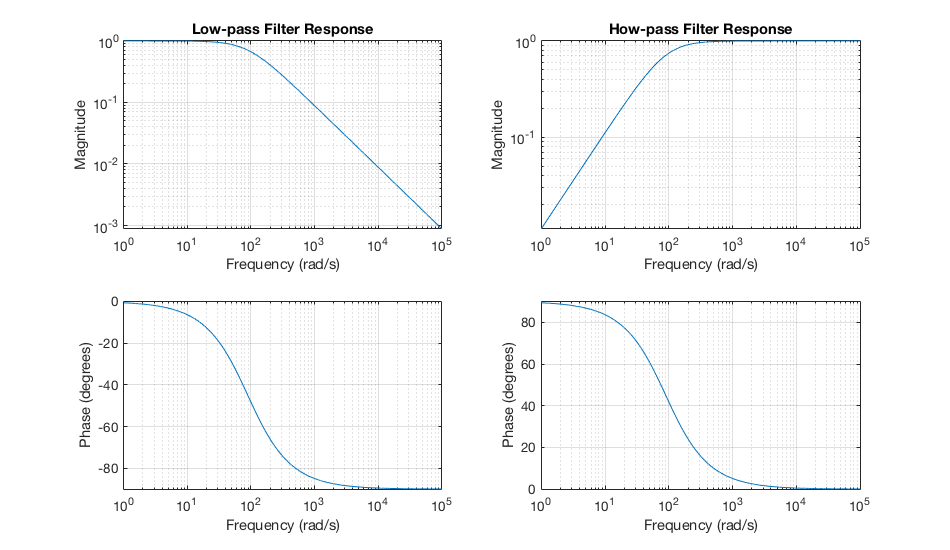

In [10]:
%plot -s 950,550
subplot(2,2,1); plot(w,abs(H1)); axis([0 max(w) 0 1]);
set(gca,'xscale','log','yscale','log'); grid on;
xlabel('Frequency (rad/s)'); ylabel('Magnitude');
title('Low-pass Filter Response')
subplot(2,2,3); plot(w,angle(H1)*180/pi); axis([0 max(w) -90 0]);
set(gca,'xscale','log'); grid on; 
xlabel('Frequency (rad/s)'); ylabel('Phase (degrees)');
subplot(2,2,2); plot(w,abs(H2)); axis([0 max(w) 0 1]);
set(gca,'xscale','log','yscale','log'); grid on;
xlabel('Frequency (rad/s)'); ylabel('Magnitude');
title('How-pass Filter Response')
subplot(2,2,4); plot(w,angle(H2)*180/pi);  axis([0 max(w) 0 90]);
set(gca,'xscale','log'); grid on;
xlabel('Frequency (rad/s)'); ylabel('Phase (degrees)');

计算输入信号(矩形脉冲)的傅里叶变换，经过频域的相乘及傅里叶反变换即得到时域上的响应：

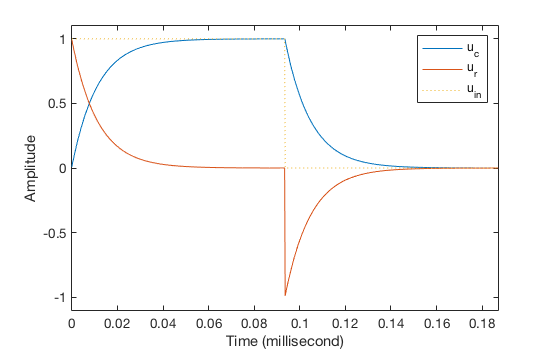

In [11]:
%plot -s 550,350
w=((0:N-1)/N-0.5)*2*pi/Ts;
jwRC=1j*tau*w;
H1=1./(1+jwRC);
H2=jwRC./(1+jwRC);
x=(t<tf/6);
X=fft(x)*Ts;

Y1=H1.*ifftshift(X);
Y2=H2.*ifftshift(X);
y1=ifft(ifftshift(Y1))/Ts;
y2=ifft(ifftshift(Y2))/Ts;


plot(t,real(y1),t,real(y2),t,x,':');
axis([0 tf/3 -1.1 1.1]);
xlabel('Time (millisecond)'); ylabel('Amplitude')
legend('u_c','u_r','u_{in}')

## 4


In [12]:
Tf=10;
N=2^10;
Ts=Tf/N;
t=(0:N-1)*Ts;
w=((0:N-1)/N-0.5)*2*pi/Ts;

系统的幅频特性和相频特性，如未安装Signal Processing工具箱，可直接写出系统函数并作图：

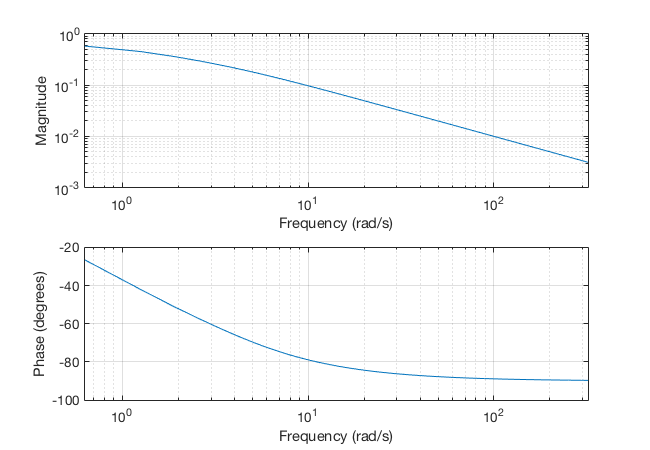

In [13]:
%plot -s 650,450
freqs([1 2],[1 4 3],w(N/2+1:N));

系统的单位冲激响应是系统频率响应的傅里叶逆变换：

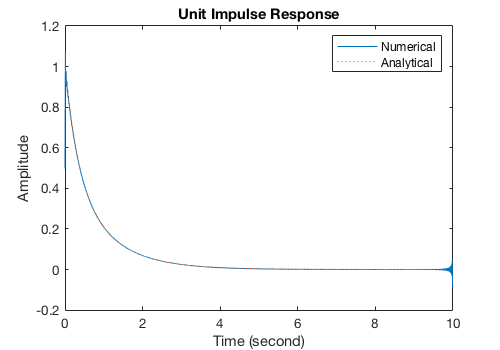

In [14]:
%plot -s 500,350
H=freqs([1 2],[1 4 3],w);
h=ifft(ifftshift(H))/Ts;

h1=0.5*exp(-t)+0.5*exp(-3*t);

plot(t,real(h),t,h1,':');
xlabel('Time (second)'); ylabel('Amplitude');
legend('Numerical','Analytical');
title('Unit Impulse Response');

系统的零状态响应。不难求出系统系统单位冲激响应的解析解为$$h\left( t \right) = \left( {\frac{1}{2}{e^{ - t}} + \frac{1}{2}{e^{ - 3t}}} \right)u\left( t \right)\;,$$当输入信号为$x\left( t \right) = {e^{ - t}}u\left( t \right)$时，系统的零状态响应为$$y\left( t \right) = \left( {\frac{1}{2}t{e^{ - t}} + \frac{1}{4}{e^{ - t}} - \frac{1}{4}{e^{ - 3t}}} \right)u\left( t \right)\;.$$本脚本给出了数值解和解析解的比较，可以看出两者给出的结果是一致的。

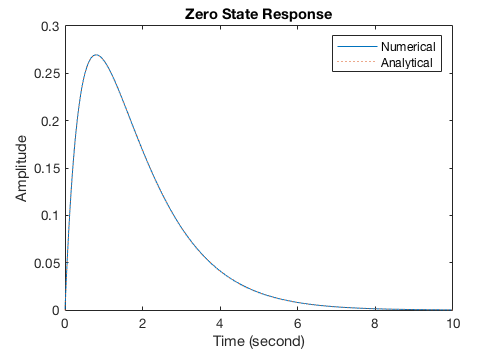

In [15]:
%plot -s 500,350
X=1./(1+1j*w);
Y=H.*X;
y=ifft(fftshift(Y))/Ts;

y1=0.5*t.*exp(-t)+0.25*exp(-t)-0.25*exp(-3*t);

plot(t,real(y),t,y1,':');
xlabel('Time (second)'); ylabel('Amplitude');
legend('Numerical','Analytical');
title('Zero State Response');